<h2> Circle detection using opencv</h2>
Written by Rasmus Emil Bjerager Madsen - rasmus.bjerager@nbi.ku.dk


This note book roughly consists of 3 sections.
- Loading and cropping of the desired video
- A calibration section where one is able to inspect individual frames and tune the parameters of the algorithm
- An analysis section where the analysis is done on all frames.


<h2>Importing packages</h2>


Firstly we need to import the packages. You probably have the all the packages except cv2. To install packages in python we may use $\textbf{pip install}$. To pip install a package, you first need to find the name of the package you need to install, in this case it is called $\textbf{opencv-python}$. Run the cell under to install the package, this needs only to be done once.

In [ ]:
#pip install opencv-python

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

<h2> Cropping of the image

Before we start the image recognition, we should crop the image, so only the section of interest is left. Additionally we should set a center line, that divides the box.

Text(0.5, 1.0, 'Cropped Image')

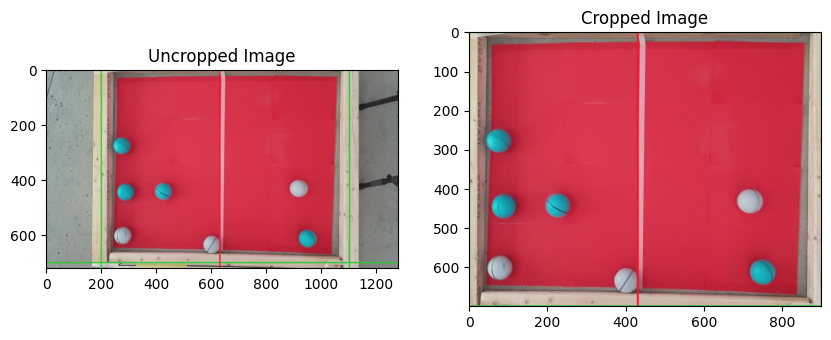

In [3]:
file = 'lowres_blandet.mp4' # Name of the video file
cap = cv2.VideoCapture(file) # Open the video file

frame = 10 # Frame to be read
i = 1
ret, image = cap.read() # Read the first frame When you call this, it returns the next frame that hvae not been returned yet
while ret:
    ret, image = cap.read() #It can count by itself 
    i += 1
    if i == frame:
        break
cap.release() # Close the video file

# Crop the image to the region of interest
x1,x2 = 200, 1100 # x1 and x2 are the left and right boundaries of the region of interest
y1,y2 = 0, 700 # y1 and y2 are the top and bottom boundaries of the region of interest
center = 630 # Center line dividing the area into left and right lanes
temp_image = image.copy() #Image to draw on
image_cal = image.copy()
# Draw the region of interest on the image
cv2.line(temp_image, (x1,0), (x1,len(image[0])), (50, 200, 50), 4) # drawing lines
cv2.line(temp_image, (x2,0), (x2,len(image[0])), (50, 200, 50), 4)
cv2.line(temp_image, (0,y1), (len(image[0,:]),y1), (50, 200, 50), 4)
cv2.line(temp_image, (0,y2), (len(image[0,:]),y2), (50, 200, 50), 4)
cv2.line(temp_image, (center, 0), (center, len(image[0])), (50, 20, 250), 4)
plt_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) #converting color values, to be compatiable with plt.imshow
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(plt_image)
ax[0].set_title('Uncropped Image')
img = plt_image[y1:y2, x1:x2].copy()
ax[1].imshow(img)
ax[1].set_title('Cropped Image')


<h2> Description of the parameters

The list is ordered so the higher up the list the parameters are, the easier they are to understand and tune.
- $\textcolor{green}{\textbf{mindist}}$: the minimum distance between two circle centers. This can be used to remove false postives that arise from the shadows of the balls.
- $\textcolor{green}{\textbf{minr}}$ and $\textcolor{green}{\textbf{maxr}}$: minimum and maximum radius of the circles detected.
- $\textcolor{lightgreen}{\textbf{par2}}$: how circle like candidates for circles are. A higher $\textcolor{lightgreen}{\textbf{par2}}$ will remove false positives and a lower $\textcolor{lightgreen}{\textbf{par2}}$ means more circles will be detected.
- $\textcolor{yellow}{\textbf{ksize}}$: the size of the kernel, basically the bigger the k, the more blurry/smoothed out the image will be. This can help the edge finding algorithm if it is increased, and it may depend on the resolution of the image. This helps remove the "flimmer" you usually see on old videotapes. $\textcolor{yellow}{\textbf{ksize}}$ may only have odd interger values.
- $\textcolor{yellow}{\textbf{par1}}$: this is a parameter the that influences what edges are detected, which are then used by the algorithm to find circles. A higher par1 will lead to more edges being detected. $\textcolor{yellow}{\textbf{par1}}$ goes well with $\textcolor{yellow}{\textbf{ksize}}$.
- $\textcolor{red}{\textbf{dp}}$: the ratio between the image resultion and the "candidate space". The algorithm discretizes the psossible centers and radii, thus a higher dp will give less candidate pixels for circle centers, and a lower will give more candidates for circles centers. 

The hardest part about finding the circles are finding the right parameters. First give rough estimates for mindist, minr and maxr. Then adjust par2 until all balls have been found. Look at different frames and try to adjust the parameters, this process will be a lot of trial and error! When you have gotten comfortable with the first parameters, then you can tweak the other more advanced parameters, this is an iterative process! When tweaking one of the advanced parameters, you might have to tweak par2 again.



"More" about the parameters: https://docs.opencv.org/4.x/d3/de5/tutorial_js_houghcircles.html

<h2>BGR values</h2>
How does an image display color? It uses the fact that a superposition of colors may create a new color. The image we are using are stored as BGR values, which stand for Blue-Green-Red. A BGR value comes on the form (b,g,r), where b, g and r can be any integer from 0 to 255. For example (255,0,0) would be blue. You might now them as RGB values, but BGR values are just shifted one position. It is rare for an image to only be one color, and there for one might have to be creative when trying to distinguish between colors from the BGR value.   

<h2>Tunning of the parameters

When trying to understand the code, try to print different variables, like $\textbf{circles}$ or $\textbf{BGR}$ 

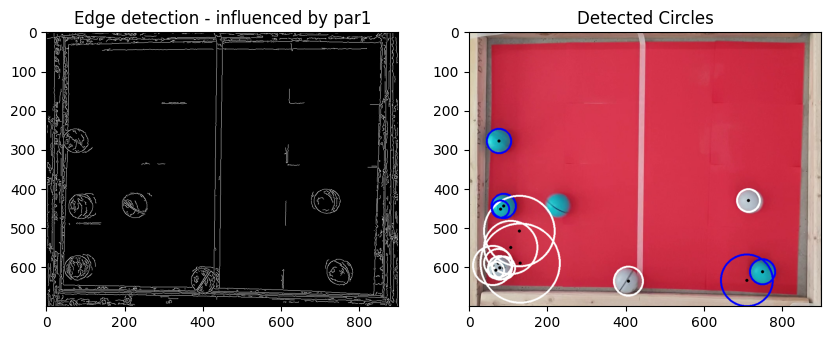

In [9]:
dp, mindist, par1, par2, minr,maxr = 0.5 ,10 ,30, 45, 5, 200 # Setting the parameters for the HoughCircles function
ksize = 3 # Setting the kernel size for the blurring. Can only be odd numbers

img = image_cal[y1:y2, x1:x2].copy()

cimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converting the image to grayscale and 
bimg = cv2.medianBlur(cimg,ksize) #Blurring it to reduce noise
circles = cv2.HoughCircles(bimg, cv2.HOUGH_GRADIENT, dp, mindist, param1=par1, param2=par2, minRadius=minr, maxRadius=maxr) # Detecting the circles
circles = np.uint16(np.around(circles[0])) # Rounding the circles to integers


for pt in circles: #We go through all the circles found
    frame = img
    x, y, r, rt  = int(pt[0]), int(pt[1]), int(0.9*pt[2]), int(pt[2]) # Extracting the x, y and r values of the circle
    C = frame[y-r:y+r, x-r:x+r] # We slice the image to get the circle
    BGR = np.nanmean(np.nanmean(C,axis=0),axis = 0) # We average the slice to find the color of the ball
    if BGR[2] < 150: # We use the BGR value to determine the color of the circle
        bgr = (255, 0, 0) #Setting the color of the circle, this color is blue
    elif BGR[2] > 150:
        bgr = (255, 255, 255)
    else:
        print('Error')
        bgr = (0, 0, 255)
    cv2.circle(img, (pt[0], pt[1]), pt[2], bgr, 3) # We draw the circle on the image
    cv2.circle(img, (pt[0], pt[1]), 1, (0, 0, 0), 5)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ax[0].imshow(cv2.Canny(bimg,par1/2, par1), cmap='gray')
ax[0].set_title('Edge detection - influenced by par1')
ax[1].imshow(plt_image)
ax[1].set_title('Detected Circles')
plt.show()


Use the left plot to adjust par1 and ksize, to remove some of the "unwanted" edges.

<h2> The analysis of the video

Finally we analyse the video. The output of will be how many blue and grey balls are in the left square. Only frames where the amount of circles being counted is the exact number we would like will be added. The frames where the are too many or to little will give an "error" message saying which frame is wrong. Additionally the total amount of "good" frames will be printed. Counting correctly 2/3 of the frames should be easily obtainable and above 9/10 is obtainable but needs a bit more tweaking. My record high is 0.96 ratio.

Frame 2 has 5 blue circles and 2 grey circles.
Frame 30 has 5 blue circles and 2 grey circles.
Frame 73 has 6 circles.
Frame 102 has 6 circles.
Frame 148 has 6 circles.
Frame 184 has 8 circles.
Frame 188 has 8 circles.
Frame 197 has 8 circles.
Frame 224 has 6 circles.
Frame 225 has 6 circles.
Frame 241 has 6 circles.
Frame 249 has 6 circles.
Frame 267 has 5 blue circles and 2 grey circles.
Frame 311 has 6 circles.
Frame 312 has 6 circles.
Frame 321 has 8 circles.
Frame 344 has 6 circles.
Frame 349 has 6 circles.
Frame 359 has 6 circles.
Frame 369 has 6 circles.
Frame 370 has 6 circles.
Frame 375 has 6 circles.
Frame 420 has 6 circles.
Frame 426 has 6 circles.
Frame 431 has 6 circles.
Frame 432 has 6 circles.
Frame 446 has 8 circles.
Frame 464 has 8 circles.
Frame 475 has 8 circles.
Frame 513 has 6 circles.
Frame 528 has 8 circles.
Frame 541 has 6 circles.
Frame 546 has 5 blue circles and 2 grey circles.
Frame 555 has 5 blue circles and 2 grey circles.
Frame 557 has 6 circles.
Frame 559

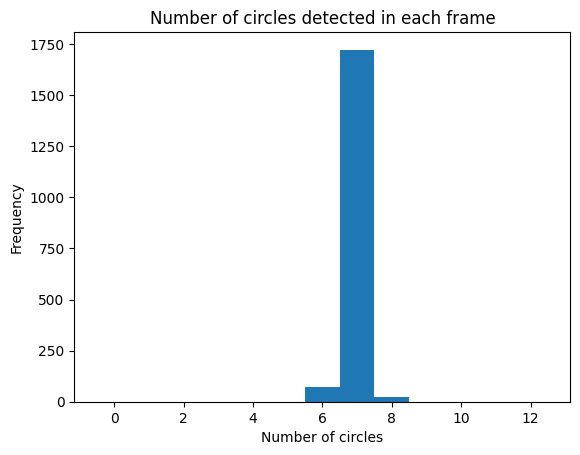

In [14]:

cap = cv2.VideoCapture(file) # Opening the video file
N_b, N_g = 4,3 # Expected number of blue and grey balls
N = N_b + N_g # Expected number of circles to detect
blue_in_left, grey_in_left = [] , [] # Making lists to store the number of blue and grey circles in the left side of the screen
c_count = [] # Making a list to store the number of circles detected in each frame
i = 1 #Frame counter
counter = 0 # Counter for the number of frames with N circles
new_center = center - x1 # Defining the center line


while True:
    ret, image = cap.read() # Getting the next frame, ret is a boolean that is True if the frame is read correctly and image is the frame
    if ret == False: # If ret is false the video is done
        break

    img = image[y1:y2, x1:x2].copy() # Cropping the image to the region of interest
    cimg = cv2.medianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),ksize) # Converting the image to grayscale and applying a median blur to reduce false positives
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, dp, mindist, param1=par1, param2=par2, minRadius=minr, maxRadius=maxr) # Detecting circles
    circles = np.uint16(np.around(circles)) # Rounding the coordinates of the circles to integers

    c_count.append(len(circles[0])) # Appending the number of circles detected in the frame to the list
    b_n, g_n = 0, 0 # Setting the counters for the number of blue and grey circles to zero
    ball_count = np.array([len(circles[0]),0,0]) # Array to keep track of total balls detected
    
    if len(circles[0]) == N: # If the number of circles detected is N
        for pt in circles[0,:]: # Looping over the circles
            frame = img
            x, y, r = int(pt[0]), int(pt[1]), int(0.9*pt[2])
            C = frame[y-r:y+r, x-r:x+r] # Getting the pixels which the circle covers
            BGR = C.mean(axis=0).mean(axis=0) # Getting the average color of the circle
            if BGR[2] < 150: # If the circle is blue
                ball_count[1] += 1
                if x < new_center: # If the circle is on the left side of the screen
                    b_n += 1
            elif BGR[2] > 150: # If the circle is grey
                ball_count[2] += 1
                if x < new_center: # If the circle is on the left side of the screen
                    g_n += 1
                    
        if ball_count[1] == N_b and ball_count[2] == N_g: # Setting certain conditions for the number of blue and grey circles
            blue_in_left.append(b_n) # Appending number of circles to the list
            grey_in_left.append(g_n)
            counter += 1
        else:
            print('Frame', i, 'has', ball_count[1], 'blue circles and', ball_count[2], 'grey circles.')
    else:
        print('Frame', i, 'has', len(circles[0]), 'circles.') # Printing frames with less or more than N circles
    i += 1
    

print('Good frames: ', counter, 'of', i ,'. Ratio: ', counter/i) # Printing the number of frames with N circles and the ratio of good frames
plt.hist(c_count, bins=np.arange(0, 2*N)-0.5) # Plot of the number of circles to see if we are getting to many or to little circles.
plt.xlabel('Number of circles')
plt.ylabel('Frequency')
plt.title('Number of circles detected in each frame')

cap.release() # Closing the video file


<h2>More reading

The Hough transforms, is not AI any more than curve_fit is. If you are interested in learning more about the algorithm here are some resources:
- Wikipedia about the general Hough transform: https://en.wikipedia.org/wiki/Hough_transform
- Article about the Hough line transform, it is easier to understand the Hough transform through a simple example: https://theailearner.com/2020/11/20/hough-line-transform/
- Video about the Hough circle transform: https://www.youtube.com/watch?v=Ltqt24SQQoI